# Building the Configuration of the Final Model

In this notebook, it is covered the conformation of the final regression model to predict cars prices. To this aim, the next steps will be followed:
* Divide the dataset into train & test values.
* Train a CatBoost Regressor with the optimal hyperparameters found.
* Predict on test data.
* Plot actual vs predicted values.
* Plot shap values to measure features impact.
* Model persistence. Saving the model with pickle.

In [1]:
import pandas as pd
import numpy as np
from time import time
import pickle
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns
sys.path.append('..')

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from modules.model_evaluator import run_cv_reg, eval_reg
from modules.plotter import plot_model_eval

## 1. Import data

In [2]:
root = r'../data/regression/cars_reg_trf.csv'

df = pd.read_csv(root)

df.head()

,year,kms,seats,power,co2_emiss,height,length,width,trunk_vol,max_speed,...,doors_2,doors_3,doors_4,doors_5,brand_encoded,model_encoded,city_encoded,color_encoded,type_encoded,chassis_encoded
0,-0.644829,-0.283562,-2.013252,-1.683986,-1.120443,0.285121,-2.877530,-2.759382,-1.498581,-2.143610,...,5.199338,-5.199338,-5.199338,-5.199338,-1.579469,-1.083566,-1.505232,-0.902609,5.199338,0.605134
1,-1.079060,-5.199338,-1.168798,1.199172,1.303557,-1.624785,-0.685567,-0.070384,-1.022354,1.345832,...,-5.199338,5.199338,-5.199338,-5.199338,0.329890,-0.367258,0.314018,-0.902609,5.199338,1.837526
2,5.199338,-5.199338,0.130979,0.494090,-0.572277,-1.297705,0.171631,-0.298225,-0.169083,0.937119,...,-5.199338,-5.199338,5.199338,-5.199338,0.829514,0.818931,0.596109,5.199338,5.199338,1.837526
3,0.060316,0.266857,0.130979,1.065669,0.635580,0.540027,0.519795,0.997262,0.429809,0.651025,...,-5.199338,-5.199338,-5.199338,5.199338,0.829514,1.653661,-1.056848,-0.902609,5.199338,1.837526
4,-1.513075,0.383683,-2.013252,2.675154,3.742522,-2.967122,0.012559,1.257931,-0.757254,-0.174181,...,5.199338,-5.199338,-5.199338,-5.199338,-1.183849,0.277283,-0.287738,-0.319300,5.199338,1.837526


## 2. Dividing the dataset

In [3]:
X = df.drop('price', axis=1)
y = df['price']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(44260, 35) (11066, 35) (44260,) (11066,)


## 3. Train CB with the optimal hyperparameters

### The hyperparameters for the `CB` have been chosen based on the results of the Grid Search cross-validation process:
- `iterations`: 1000
- `learning_rate`: 0.12
- `depth`: 8
- `l2_leaf_reg`: 0.1

Moreover, I will include two parameters when fitting the model to avoid overfitting (refer to [this doc](https://catboost.ai/docs/features/overfitting-detector-desc.html) for further details):
- `od_type`: Type of overfitting detector. I have chosen "Iter".
- `od_wait`: The number of iterations to continue the training after the iteration with the optimal metric value. I have picked "10". Together with the "Iter" detector, it considers the model overfitted and stop training after the specified number of iterations since the iteration with the optimal metric value.
- `early_stopping_rounds`: Take into account both `od_type` and `od_wait`.

In [5]:
start_time = time()

cb = CatBoostRegressor(depth=8,
                       learning_rate=0.12,
                       l2_leaf_reg=0.1,
                       iterations=1000,
                       eval_metric='R2',
                       verbose=False)

cb.fit(X_train, y_train, early_stopping_rounds=10) # od_type="Iter", od_wait=10

exec_time = time() - start_time
print('The CB model was trained in: {:.2f} sec'.format(exec_time))

The CB model was trained in: 22.58 sec


In [6]:
# Parameters
pd.DataFrame(cb.get_all_params()).T

,tags
nan_mode,Min
eval_metric,R2
iterations,1000
sampling_frequency,PerTree
leaf_estimation_method,Newton
od_pval,0
grow_policy,SymmetricTree
penalties_coefficient,1
boosting_type,Plain
model_shrink_mode,Constant


## 4. Predict on test data: Evaluation of the model

In [7]:
y_hat = cb.predict(X_test)

display(y_hat)
print("Min value predicted: {:.2f}\n\
Max value predicted: {:.2f}"\
      .format(np.min(y_hat), np.max(y_hat)))
print("y_hat shape: {}".format(y_hat.shape))

array([15099.47462345,  9812.05527315,  8882.52463561, ...,
       23758.94578056, 14560.29011876, 10677.41929392])

Min value predicted: -65.46
Max value predicted: 103362.82
y_hat shape: (11066,)


Time to evaluate the prediction of the model. It needs to be generalized using cross-validation to verify if the model is stable and feasible to be used on new inputs.

![Under- and overfitting](https://djsaunde.files.wordpress.com/2017/07/bias-variance-tradeoff.png)

In [8]:
models = []
models.append(('CB', cb))

df_models, results = run_cv_reg(X, y, models, 'r2')

Executing CB...
CV finished for CB


In [9]:
df_models

,model,min_r2_score,1st_quantile,median_r2_score,mean_r2_score,std_r2_score,3rd_quantile,max_r2_score,exec_time_sec
0,CB,0.9401,0.943,0.9453,0.9457,0.0036,0.9471,0.9528,213.6599


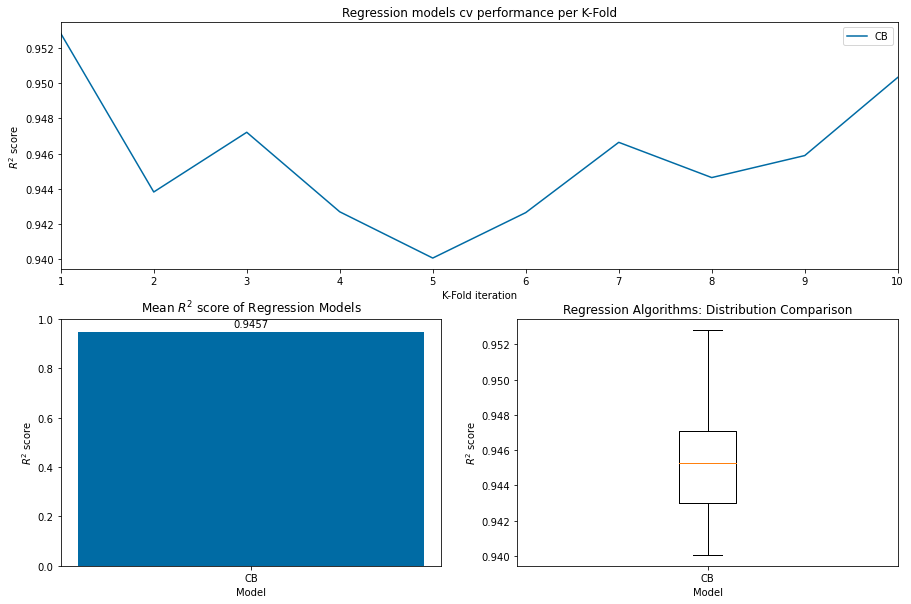

In [10]:
plot_model_eval(df_models, results)
plt.savefig('fig/12_model_cb_cv.png')
plt.show()

In [11]:
eval_reg(y_test, y_hat)

### MEASURES OF REGRESSION MODEL ###
------------------------------------

R2 = 0.9410

RMSE = 3127.9631

MSE = 9784153.1474

MSLE not possible to be applied. Predicitons contain negative values.

MAE = 1748.0986

EVS = 94.1026%



## 5. Actual vs Predicted values: Residual Plots

First, let's have a look at the predicted values that the model produced related to each feature:

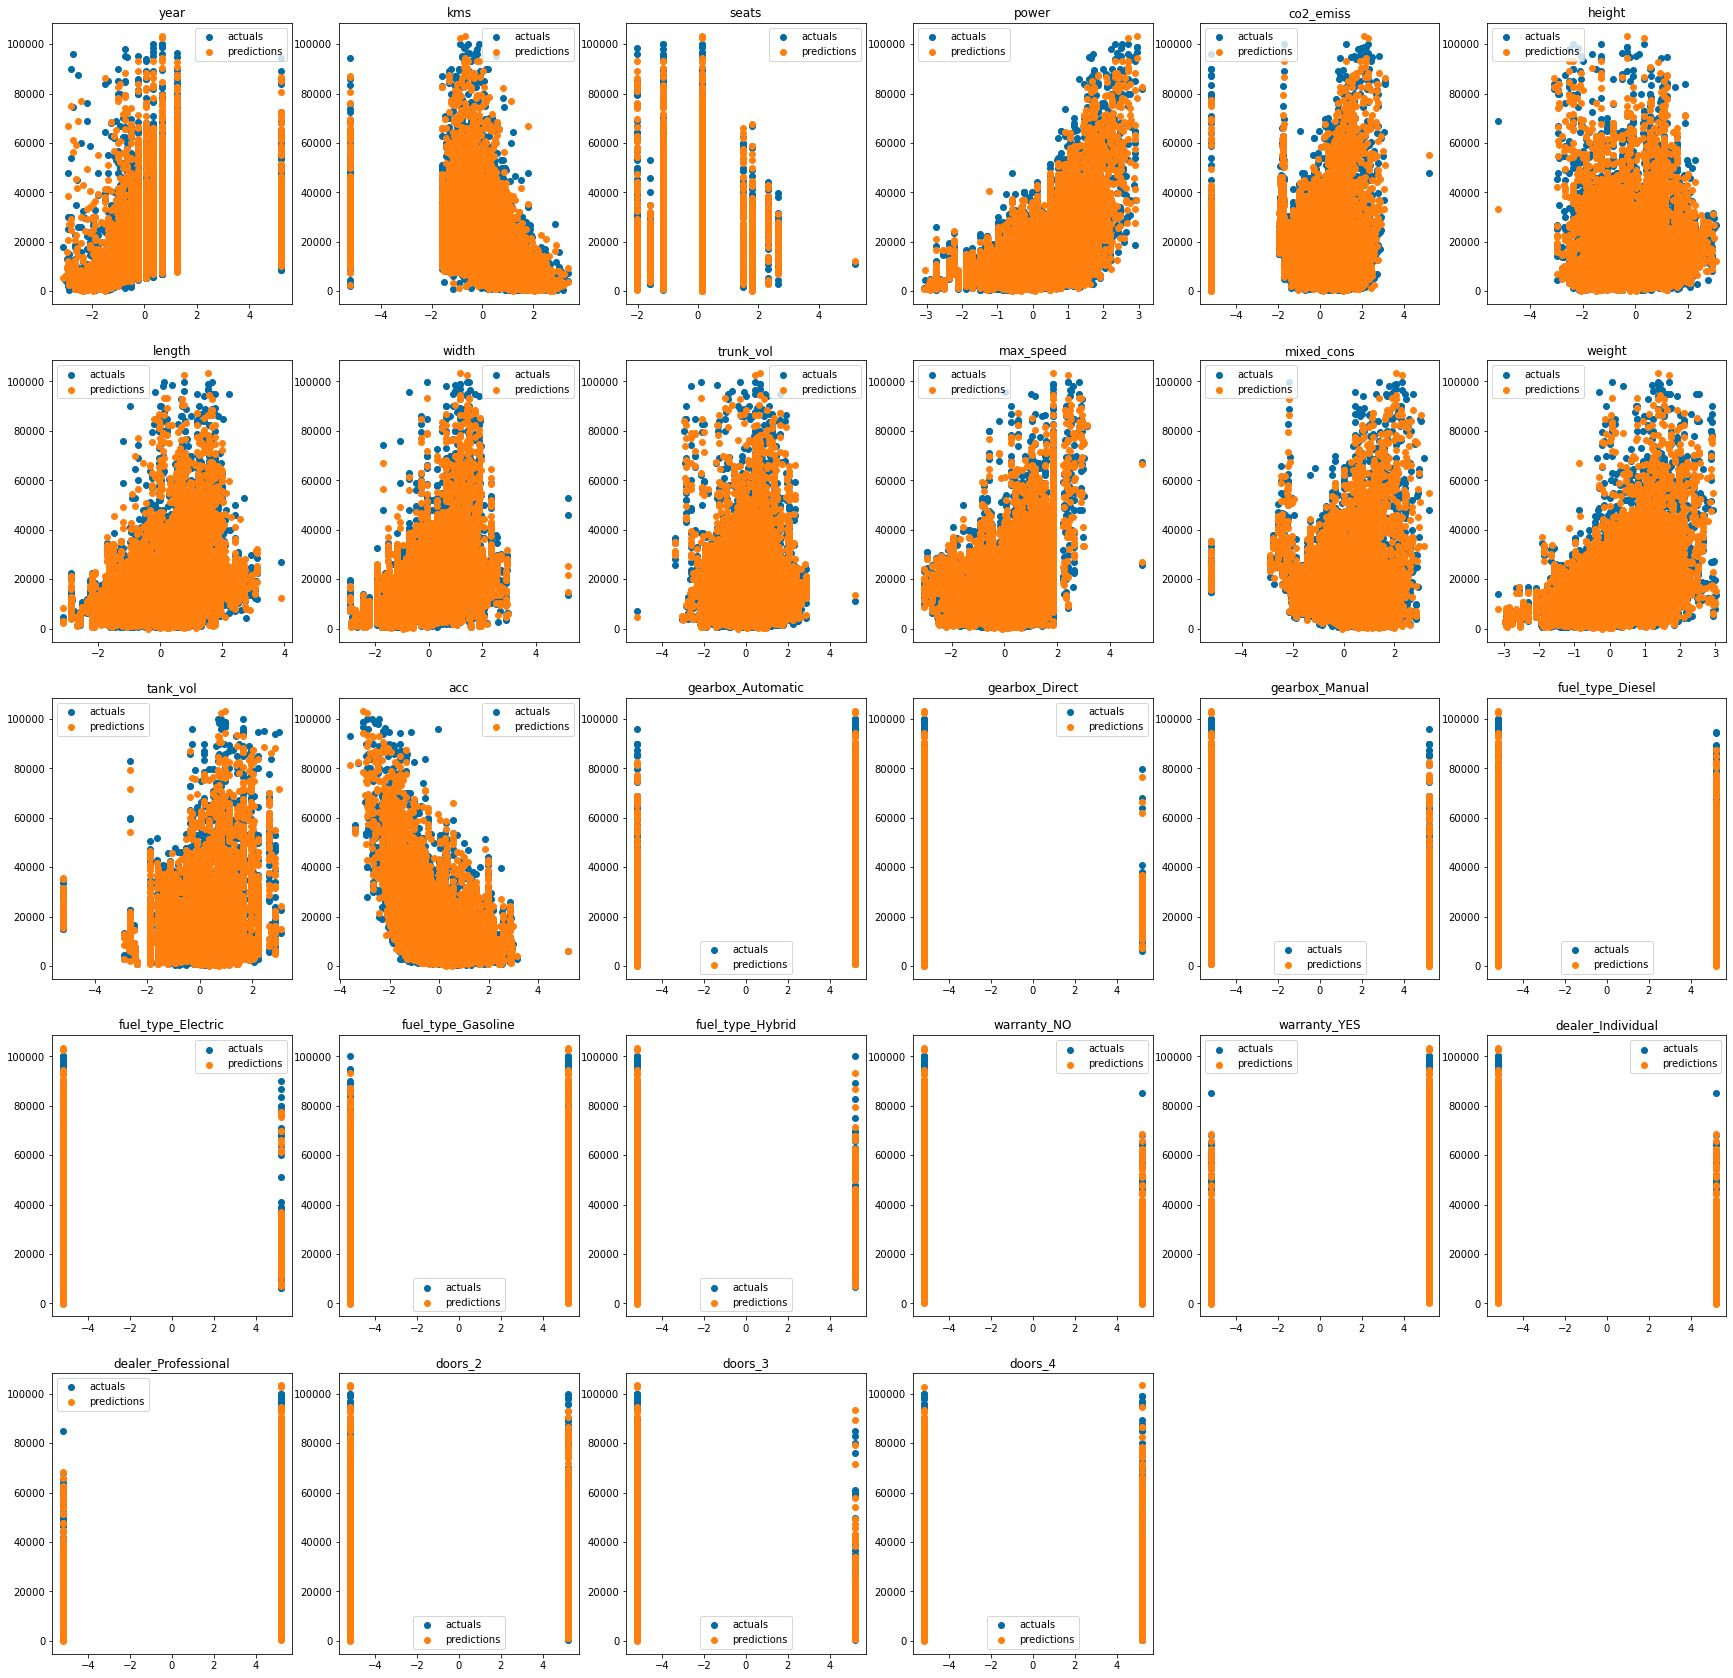

In [12]:
fig = plt.figure(figsize=(30,30))

columns = X_test.columns

for c, num in zip(columns, range(0,28)):
    ax = fig.add_subplot(5, 6, num+1)
    ax.scatter(X_test[c], y_test)
    ax.scatter(X_test[c], y_hat)
    ax.set_title(c)
    ax.legend(['actuals', 'predictions'])
    
plt.savefig('fig/12_columns_pred_cb.png')
plt.show()

It is visible that the values are correctly predicted, especially for cheaper cars. This is due to the fact that the dataset has less samples of luxury second-hand cars. Now, we will have a look at the predictions of the whole model to see how they are adapted to actual values.

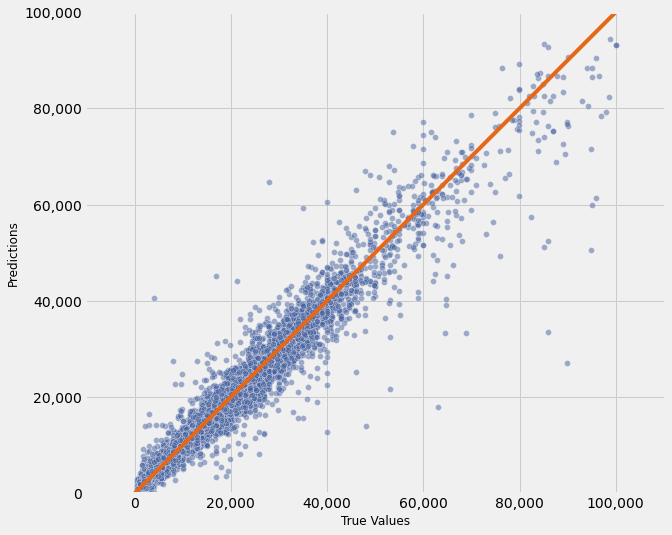

In [13]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(9.25, 8.25))

sns.scatterplot(x=y_test, y=y_hat, color='#4863A0', alpha=0.5)

p1 = max(max(y_hat), max(y_test))
p2 = min(min(y_hat), min(y_test))
sns.lineplot(x=[p1, p2], y=[p1, p2], color='#E56717')

plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.axis('equal')
plt.xlim(xmin=0, xmax=100000)
plt.ylim(ymin=0, ymax=100000)

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.savefig('fig/12_model_pred_cb.png', bbox_inches='tight')
plt.show()

From the above scatter plot of Actual vs Predicted values, it is possible to take the following conclusions:
- The closer the scatter points are to the regression line, the better the model. The $R²\ score$ obtained was of **0.9457**, which is a high score. This results in all the points being close to the diagonal line. The lower the $R²\ score$, the weaker the goodness of fit of the model.
- Having a deeper look into the values, we can conclude that the higher the price of the car, the more dispersed is the model. This affirmation was already visible when analysing the prediction of each feature. The number of second-hand cars with a value higher than **50,000 €** are scarce compared to more accessible cars. Therefore, we could expect a better performance of the model when predicting prices of non-luxury cars.
- Residual values are those separated from the regression line. If they are above the line, they are positive, whereas if they are below, they are negative. Residuals seem to be balanced for lower prices, nevertheless negative values seem to be predominant with higher prices. Thereupon, there can be underestimations on predicting cars with a higher market value.

In any case, the performance of our model will be more than acceptable since the points are fit to the regression line and the $R²\ score$ value is close to **0.95**.

## 6. Shap Figures

The _Shapley value_ consists on this theory:

>A coalition of players cooperates, and obtain a final overall gain for the cooperation. Some players will contribute more to the coalition than other or even a different bargaining power (they could threat to destroy the total surplus). Therefore, the Shapley values answer these questions: how important is each player to the overall cooperation, and what payoff can they reasonably expect?

In order to visualize which features have a greater impact to the model, we can plot the SHAP (**SH**apley **A**dditive ex**P**lnations) values for every feature and every sample. Features are sorted by the sum of SHAP value magnitudes over all samples, and SHAP plot shows the distribution of the impacts each feature has on the model output.

The color represents feature values (red is high, blue is low). This explains for example that a low manufactured year, lowers the final predicted car price. What is more, cars with a high horse power, will result on a higher prection. Finally, the higher the total number of kilometers of the car, the lower the price.

In [14]:
import shap

In [15]:
explainer = shap.Explainer(cb)
shap_values = explainer(X)

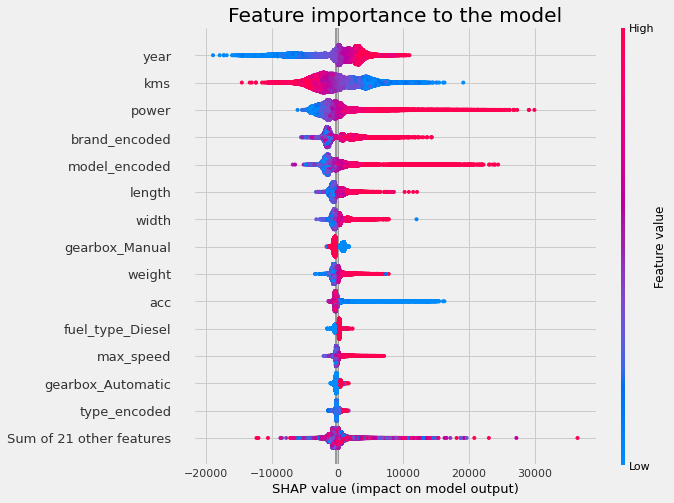

In [16]:
plt.title('Feature importance to the model')
shap.plots.beeswarm(shap_values, max_display=15, show=False)
plt.savefig('fig/12_shap_model_distribution.png', bbox_inches='tight')
plt.show()

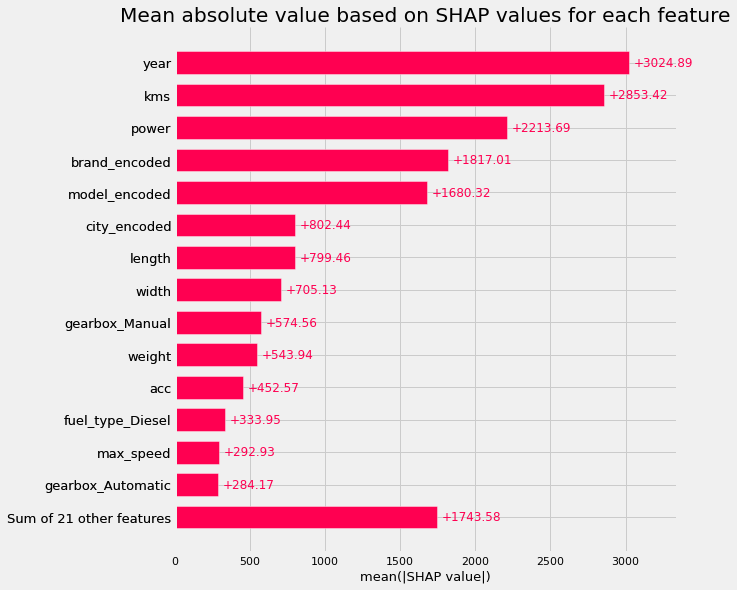

In [17]:
plt.title('Mean absolute value based on SHAP values for each feature')
shap.plots.bar(shap_values, max_display=15, show=False)
plt.savefig('fig/12_shap_model_barplot.png', bbox_inches='tight')
plt.show()

---

## 7. Model persistence

<img align="center" src="https://programaenlinea.net/wp-content/uploads/2017/09/python-pickle-800x200.png">

In [18]:
from modules.pickle_jar import create_pickle, compressed_pickle, decompress_pickle
from pathlib import Path
import os

Defining the model to be saved. The fit will be based on the entire dataset to enrich the model, no separations into train & test sets. This process is based on the explanation of compressed pickles commented in [this article](https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e).

In [19]:
cb_model = CatBoostRegressor(depth=8,
                             learning_rate=0.12,
                             l2_leaf_reg=0.1,
                             iterations=1000,
                             eval_metric='R2',
                             verbose=False)

cb_model.fit(X, y, early_stopping_rounds=10)

Time to save this model using pickle!

In [20]:
create_pickle("models/cb_model.pkl", cb_model)

In [21]:
Path("models/cb_model.pkl").stat().st_size

4184211

In [22]:
compressed_pickle("models/cb_model", cb_model)

In [23]:
Path("models/cb_model.pbz2").stat().st_size

1194586

In [24]:
size_rel = Path("models/cb_model.pkl").stat().st_size / Path("models/cb_model.pbz2").stat().st_size
print("Pickle wo/ being compressed is {:.2f}% heavier in size.".format(size_rel * 100))

Pickle wo/ being compressed is 350.26% heavier in size.


Since the size of the compressed file is much lighter in size, we will use this one and delete the normal pickle version.

In [25]:
os.remove("models/cb_model.pkl")

Let's see if we can decompress and load the created pickle:

In [26]:
pickle_model = decompress_pickle("models/cb_model.pbz2")

In [27]:
score = pickle_model.score(X_test, y_test)
print("Test score: {:.2f}%".format(score * 100))
y_predict = pickle_model.predict(X_test)

Test score: 98.37%


### We finally saved our model in a pickle jar!
<img width=500 src="https://i.pinimg.com/originals/93/c2/64/93c264fed54a077870340f043d6b3667.jpg">
Now it is possible to reuse this model and apply it to new data. Time to explore its performance!